<a href="https://colab.research.google.com/github/cblh/TorchLeet/blob/main/torch/medium/lstm/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem: Implement an LSTM Model

### Problem Statement
You are tasked with implementing a simple **LSTM (Long Short-Term Memory)** model in PyTorch. The model should process sequential data using an LSTM layer followed by a fully connected (FC) layer. Your goal is two-fold: one is to implement a LSTM layer from scratch and another using inbuilt pytorch LSTM layer. Compare the results implementing the forward passes for both the LSTM models.

### Requirements
1. **Define the LSTM Model using Custom LSTM layer**:
   - Add a `Custom` LSTM layer to the model. The layer must take care of the hidden and cell states
   - Add a **fully connected (FC) layer** that maps the output of the LSTM to the final predictions.
   - Implement the `forward` method to:
     - Pass the input sequence through the LSTM.
     - Feed the output of the LSTM into the fully connected layer for the final output.

2. **Define the LSTM Model using in-built LSTM layer**:
  - Same as `1` with only difference that this time define the LSTM layer using pytorch `nn.Module`

### Constraints
- The LSTM layer should be implemented with a single hidden layer.
- Use a suitable number of input features, hidden units, and output size for the task.
- Make sure the `forward` method returns the output of the fully connected layer after processing the LSTM output.


<details>
  <summary>💡 Hint</summary>
  Add the LSTM layer and FC layer in LSTMModel.__init__.
  <br>
  Implement the forward pass to process sequences using the LSTM and FC layers.
  <br> Review Hidden and cell states computation here: [D2l.ai](https://d2l.ai/chapter_recurrent-modern/lstm.html)
</details>

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [78]:
# Generate synthetic sequential data
torch.manual_seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
y = torch.sin(X)

# Prepare data for LSTM
def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return torch.stack(in_seq), torch.stack(out_seq)

X_seq, y_seq = create_in_out_sequences(y, sequence_length)

In [79]:
class CustomLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_units):

        super().__init__()
        def normal(shape):
            return torch.randn(size=shape)*0.01
        def three():
            return (normal((input_dim, hidden_units)),
                   normal((hidden_units, hidden_units)),
                   torch.zeros(hidden_units))

        W_xi, W_hi, b_i = three()  # 输入门参数
        W_xf, W_hf, b_f = three()  # 遗忘门参数
        W_xo, W_ho, b_o = three()  # 输出门参数
        W_xc, W_hc, b_c = three()  # 候选记忆元参数
        # 输出层参数
        self.fc = nn.Linear(hidden_units, 1)
        self.hidden_units = hidden_units
        self.params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c]

    def forward(self, inputs, H_C=None):
        def init_lstm_state(batch_size, num_hiddens):
            return (torch.zeros((batch_size, num_hiddens)),
                    torch.zeros((batch_size, num_hiddens)))
        batch_size, seq_len, _ = inputs.size()
        if H_C is None:
            H_C = init_lstm_state(batch_size, self.hidden_units)
        [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = self.params
        (H, C) = H_C
        outputs = []
        for t in range(seq_len):
            X = inputs[:, t, :]
            I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
            F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
            O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
            C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
            C = F * C + I * C_tilda
            H = O * torch.tanh(C)
            outputs.append(H.unsqueeze(1))
        return self.fc(torch.cat(outputs, dim=1)), (H, C)

In [80]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM
        return out

In [81]:
# Initialize the model, loss function, and optimizer
model_custom = CustomLSTMModel(1, 50)
model_inbuilt = LSTMModel()
criterion = nn.MSELoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.01)
optimizer_inbuilt = optim.Adam(model_inbuilt.parameters(), lr=0.01)

In [82]:
# Training loop for the custom model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    state = None
    pred, state = model_custom(X_seq, state)
    loss = criterion(pred[:, -1, :], y_seq) # Use the last output of the LSTM
    # Backward pass and optimization
    optimizer_custom.zero_grad()
    loss.backward()
    optimizer_custom.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 0.4306
Epoch [100/500], Loss: 0.3623
Epoch [150/500], Loss: 0.3032
Epoch [200/500], Loss: 0.2525
Epoch [250/500], Loss: 0.2094
Epoch [300/500], Loss: 0.1730
Epoch [350/500], Loss: 0.1428
Epoch [400/500], Loss: 0.1178
Epoch [450/500], Loss: 0.0975
Epoch [500/500], Loss: 0.0811


In [83]:
# Training loop for the inbuilt model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    pred = model_inbuilt(X_seq)
    loss = criterion(pred, y_seq)
    # Backward pass and optimization
    optimizer_inbuilt.zero_grad()
    loss.backward()
    optimizer_inbuilt.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 0.0010
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


In [84]:
# Testing on new data
test_steps = 100  # Ensure this is greater than sequence_length
X_test = torch.linspace(0, 5 * 3.14159, steps=test_steps).unsqueeze(1)
y_test = torch.sin(X_test)

# Create test input sequences
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)

with torch.no_grad():
    pred_custom, _ = model_custom(X_test_seq)
    pred_inbuilt = model_inbuilt(X_test_seq)
pred_custom = torch.flatten(pred_custom[:, -1, :])
pred_inbuilt = pred_inbuilt.squeeze()
print(f"Predictions with Custom Model for new sequence: {pred_custom.tolist()}")
print(f"Predictions with In-Built Model: {pred_inbuilt.tolist()}")


Predictions with Custom Model for new sequence: [0.573171854019165, 0.5950174331665039, 0.6010242104530334, 0.5910398364067078, 0.5653182864189148, 0.524513304233551, 0.469661146402359, 0.40215376019477844, 0.3237023651599884, 0.23629312217235565, 0.1421356350183487, 0.04360615834593773, -0.05681354179978371, -0.15659889578819275, -0.253246545791626, -0.34433695673942566, -0.42759430408477783, -0.5009424686431885, -0.5625553131103516, -0.6109011769294739, -0.6447794437408447, -0.6633493900299072, -0.6661497354507446, -0.6531102657318115, -0.6245532035827637, -0.5811859369277954, -0.524084210395813, -0.45466670393943787, -0.37466102838516235, -0.2860620617866516, -0.1910831332206726, -0.0921018198132515, 0.008399177342653275, 0.10789373517036438, 0.2038765400648117, 0.293926477432251, 0.37576836347579956, 0.4473315179347992, 0.506803035736084, 0.5526750683784485, 0.5837833881378174, 0.5993381142616272, 0.5989444851875305, 0.5826127529144287, 0.5507580041885376, 0.5041897296905518, 0.444

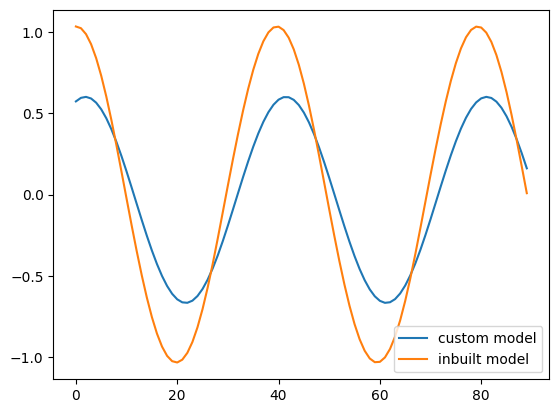

In [85]:
#Plot the predictions
plt.figure()
# plt.plot(y_test, label="Ground Truth")
plt.plot(pred_custom, label="custom model")
plt.plot(pred_inbuilt, label="inbuilt model")
plt.legend()
plt.show()